# Predictive Modeling of FDM 3D-Printing Parameters and Performance Metrics

### Introduction

In this notebook, we transition from exploratory analysis to constructing and evaluating a suite of predictive models for our 3D printing dataset.  Using the same mechanical (e.g., layer height, wall thickness, and infill pattern) and thermal (e.g., nozzle/bed temperature and fan speed) process settings we will:  
1. Establish simple, constant baselines.
2. Train and compare three core regressors—Linear Regression, Random Forest, and XGBoost—using a standardized preprocessing pipeline and 5-fold cross-validation.
3. Combine their out-of-fold (OOF) predictions into a hill climbing ensemble.

This framework lays the groundwork for robust, deployable ML models for real-time print quality prediction and process optimization.

- Dataset source: https://www.kaggle.com/datasets/afumetto/3dprinter?select=data.csv

### Load the dataset

In [1]:
import pandas as pd


# Load the dataset from defined path
FILENAME = 'data.csv'
df = pd.read_csv(FILENAME)

# Inspect the data
print(f'Shape: {df.shape}.')
df.head()

Shape: (50, 12).


,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tension_strenght,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


### Standardize column names and values

In [2]:
# Ensure all columns are lower-case (as some datasets are mixed)
for col in df:
    df.rename(columns={col: col.lower()}, inplace=True)

# Rename misspelled column
df.rename(columns={'tension_strenght': 'tension_strength'}, inplace=True)

# Capitalize material column
df['material'] = df['material'].str.upper()

### Data preparation

First, we need to prepare our data by splitting between features and targets.

In [3]:
# Define targets
all_targets = ['roughness', 'tension_strength', 'elongation']
target = 'elongation'

# Prepare data
X = df.drop(columns=all_targets)
y = df[target]

Next, we establish our k-fold cross-validation splitter as well as the scoring metrics we will use for evaluating the baseline. For scoring we will use RMSE.

In [4]:
from sklearn.model_selection import KFold


# Fix randomness
SEED = 42
N_FOLD = 5
METRIC = 'RMSE'  # 'RMSE', 'MAE'
base_models = []
USE_FILTER = True  # Filter for univariate relevance and redundancy

# 5-fold CV splitter
kf = KFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

if METRIC not in ['RMSE', 'MAE']:
    raise ValueError(f'Unaccounted for metric: {METRIC}.')

# Create strategies and  define corresponding metric scorers
if METRIC == 'RMSE':
    strategy = 'mean'
    score_metric = 'neg_root_mean_squared_error'
elif METRIC == 'MAE':
    strategy = 'median'
    score_metric = 'neg_mean_absolute_error'

### Determine the Naive baseline

Scikit-learn assumes every scorer is something we want to maximize. That works great for accuracy or R^2, but for error metrics where "better" is smaller (e.g., RMSE and MAE) this doesn't work. To account for that we will use sklearn's "negative" version of the relevant scorers which effectively return the negative value of the metric for scoring purposes. We will use the mean as a constant-prediction baseline as the mean is better suited for an RMSE‐based baseline while the median is better suited for an MAE‐based baseline.

In [5]:
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score


# Instantiate Dummy baseline and get negative‐RMSE scores
baseline = DummyRegressor(strategy=strategy)
neg_metric = cross_val_score(baseline, X, y, cv=kf, scoring=score_metric)

# Build a one‐row DataFrame with a MultiIndex
baseline_df = pd.DataFrame({f'{METRIC} (CV)': [-neg_metric.mean()], 'strategy': strategy},
    index=pd.MultiIndex.from_tuples(
        [(target, 'Baseline')], 
        names=['target','model']
    )
)
print('Baseline Model:\n', baseline_df)

Baseline Model:
                      RMSE (CV) strategy
target     model                       
elongation Baseline   0.800207     mean


### Filter for Univariate Relevance and Redundancy

We will filter our raw feature set in two stages to improve model robustness and interpretability. First, **univariate relevance filtering** removes numeric features with low Spearman $\rho$ and categorical features with negligble mutual information. Next, **redundancy filtering** iteratively removes multicollinear numerics based on variance-inflation factors and highly associated cateogrical pairs using bias-corrected Cramer's V. This results in a non-redundant set of inputs associated with our target for our regression models.

In [6]:
# First, build a DF for features + target (ignoring other potential targets)
df_filt = pd.concat([X, y], axis=1)

In [7]:
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder


def encode_cats_safe(df, cat_cols):
    """
    Return a dense 2-D numpy array with:
      • NaN  ->  literal string 'MISSING'
      • Ordinal-encoded integers 0..n_cat-1 (−1 = unseen at test time)
    """
    X_cat = df[cat_cols].fillna('MISSING')
    enc = OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,
        dtype=np.int64,
    )
    return enc.fit_transform(X_cat), enc


def filter_relevance(df, target, spearman_tol=0.10, mi_tol=0.0):
    """
    Univariate relevance filter (numeric uses ρ, categorical uses MI).
    """
    y  = df[target]
    X  = df.drop(columns=[target])
    nums = X.select_dtypes('number').columns.tolist()
    cats = X.select_dtypes(exclude='number').columns.tolist()

    surv_num, surv_cat, dropped, mi_map = [], [], [], {}

    # numeric variables use Spearman ρ
    for col in nums:
        ρ, _ = spearmanr(X[col], y, nan_policy='omit')
        if np.isnan(ρ) or abs(ρ) < spearman_tol:
            dropped.append((col, 'Relevance-Num', f'|ρ|={ρ:.3f}< {spearman_tol}'))
        else:
            surv_num.append(col)

    # categorical variables use MI
    if cats:
        X_cat_enc, _ = encode_cats_safe(X, cats)
        mi = mutual_info_regression(
            X_cat_enc, y, discrete_features=True, random_state=0)
        for col, m in zip(cats, mi):
            mi_map[col] = m
            if m <= mi_tol:
                dropped.append((col, 'Relevance-Cat', f'MI={m:.3f}≤ {mi_tol}'))
            else:
                surv_cat.append(col)

    return surv_num, surv_cat, dropped, mi_map


# Filter initial features based on relevance to target if filtering
if USE_FILTER:
    relev_surv_num, relev_surv_cat, relev_dropped, mi_map = filter_relevance(df_filt, target, spearman_tol=0.05, mi_tol=0.0)

In [8]:
from itertools import combinations

from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor


def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """Helper for bias-corrected Cramer's V."""
    conf = pd.crosstab(x, y)
    chi2 = chi2_contingency(conf, correction=False)[0]
    n = conf.values.sum()
    phi2 = chi2 / n
    r, k = conf.shape
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    r_corr   = r - ((r - 1)**2) / (n - 1)
    k_corr   = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2_corr / max(1, min(r_corr - 1, k_corr - 1)))


def prepare_vif_matrix(df, num_cols):
    """
    Return numeric matrix ready for VIF:
      • median-impute only if NaNs are present
      • assert finite values
    """
    X_num = df[num_cols]
    if X_num.isna().any().any():
        X_num = pd.DataFrame(
            SimpleImputer(strategy="median").fit_transform(X_num),
            columns=num_cols, index=df.index
        )

    # optional: guard against inf
    if np.isinf(X_num.values).any():
        raise ValueError("Found ±inf in numeric data; handle before VIF.")

    return X_num
    

def filter_redundancy(df,
                      cand_num, cand_cat,
                      mi_map,
                      vif_tol=5.0, cv_tol=0.80):
    """Redundancy filter (numeric uses VIF, categorical uses Cramer-V)."""
    dropped = []

    # ---- numeric: iterative VIF pruning ----
    cand_num = cand_num.copy()
    while len(cand_num) > 1:
        X_num = prepare_vif_matrix(df, cand_num)
        X_vif = X_num.assign(const=1.0)

        # Suppress the divide‐by‐zero warning, but keep the inf values
        with np.errstate(divide='ignore', invalid='ignore'):
            vifs = [
                variance_inflation_factor(X_vif.values, i)
                for i in range(len(cand_num))
            ]
            
        max_v = np.nanmax(vifs)
        if max_v <= vif_tol:
            break
        drop_idx = vifs.index(max_v)
        dropped.append((cand_num[drop_idx], 'Redundancy-Num',
                        f'VIF={max_v:.1f}> {vif_tol}'))
        cand_num.pop(drop_idx)

    # ---- categorical: Cramer-V pruning with tie-breaker ----
    na_ratio = df.isna().mean()
    cardinal = df.nunique()

    def choose_drop(a, b):
        """Return the worse of (a,b) by MI ↓, NaNs ↑, cardinality ↑, alpha ↑."""
        keys = ('mi', 'na', 'card', 'alpha')
        vals_a = (mi_map.get(a, 0), na_ratio[a], cardinal[a], a)
        vals_b = (mi_map.get(b, 0), na_ratio[b], cardinal[b], b)
        return a if vals_a < vals_b else b  # keep the "better", drop the other

    cand_cat = cand_cat.copy()
    for c1, c2 in combinations(cand_cat, 2):
        if c1 not in cand_cat or c2 not in cand_cat:
            continue
        v = cramers_v(df[c1], df[c2])
        if v > cv_tol:
            drop = choose_drop(c1, c2)
            keep = c2 if drop == c1 else c1
            cand_cat.remove(drop)
            dropped.append((drop, 'Redundancy-Cat',
                            f'V={v:.2f}> {cv_tol} vs {keep}'))

    return cand_num, cand_cat, dropped


# Filter initial features based on redundancy with one another if filtering
if USE_FILTER:
    final_surv_num, final_surv_cat, redun_dropped = filter_redundancy(df_filt, relev_surv_num, relev_surv_cat, mi_map)

In [9]:
# Determine surviving columns for subsequent filtering
surv_cols = final_surv_num + final_surv_cat if USE_FILTER else list(X.columns)
X_of_interest = X[surv_cols]

# One‐hot encode the categorical survivors
X_enc = pd.get_dummies(X_of_interest, drop_first=True)

# Derive numeric vs. categorical on the filtered DataFrame
nums = X_of_interest.select_dtypes(include='number').columns.tolist()
cats = X_of_interest.select_dtypes(exclude='number').columns.tolist()
assert set(nums+cats) == set(X_of_interest.columns)

print(f'There are a total of {len(X_of_interest.columns)} features:')
for i, feature in enumerate(X_of_interest.columns, start=1):
    print(f'\t#{i}: {feature}')

There are a total of 7 features:
	#1: layer_height
	#2: wall_thickness
	#3: infill_density
	#4: nozzle_temperature
	#5: print_speed
	#6: fan_speed
	#7: material


## Linear Regression

In [10]:
def compare_baseline_and_model_metric(baseline_df, model_df, metric):
    """Compare a DummyRegressor baseline vs. a fitted model."""
    metric_col = f'{metric} (CV)'
    model_name = model_df.reset_index()['model'][0]

    # Extract the baseline series (index: target)
    baseline_ser = (
        baseline_df
        .xs('Baseline', level='model')[metric_col]
        .rename('Baseline')
    )

    # Extract the model series
    model_ser = (
        model_df
        .xs(model_name, level='model')[metric_col]
        .rename(model_name)
    )

    # Join into one DataFrame
    comp = pd.concat([baseline_ser, model_ser], axis=1)

    return comp.reset_index()

In [11]:
from sklearn.linear_model import LinearRegression


# Instantiate LR and get negative‐RMSE scores
model_name = 'LinearRegression'
lr = LinearRegression()
neg_metric = cross_val_score(lr, X_enc, y, cv=kf, scoring=score_metric)

# Build a one‐row DataFrame with a MultiIndex
initial_df_lr = pd.DataFrame(
    {f'{METRIC} (CV)': [-neg_metric.mean()]},
    index=pd.MultiIndex.from_tuples(
        [(target, model_name)], 
        names=['target','model'],
    )
)
print(initial_df_lr)

                             RMSE (CV)
target     model                      
elongation LinearRegression   0.479899


In [12]:
# Compare baseline with linear regression model
lr_comparison = compare_baseline_and_model_metric(baseline_df, initial_df_lr, METRIC)
lr_comparison.round(3)

,target,Baseline,LinearRegression
0,elongation,0.8,0.48


In [13]:
if METRIC not in ['RMSE', 'MAE']:
    raise ValueError(f'Unaccounted for metric for error comparison: {METRIC}.')

# Check if the new model improves on every target
better = (lr_comparison[model_name] < lr_comparison['Baseline']).all()

# Store the base LinearRegression model as it is better than the baseline
if better:
    print(f'Appending {model_name} to base models.')
    base_models.append((model_name, lr))
else:
    print(f'{model_name} did not beat the baseline on every target.')

Appending LinearRegression to base models.


## Random Forest Regression

In [14]:
from sklearn.ensemble import RandomForestRegressor


# Instantiate RF and get negative‐RMSE scores
model_name = 'RandomForest'
rf = RandomForestRegressor(n_estimators=100, random_state=SEED)
neg_metric = cross_val_score(rf, X_enc, y, cv=kf, scoring=score_metric)

# Build a one‐row DataFrame with a MultiIndex
initial_df_rf = pd.DataFrame(
    {f'{METRIC} (CV)': [-neg_metric.mean()]},
    index=pd.MultiIndex.from_tuples(
        [(target, model_name)], 
        names=['target','model'],
    )
)

print(initial_df_rf)

                         RMSE (CV)
target     model                  
elongation RandomForest   0.480019


In [15]:
# Compare baseline and Random Forest regression
rf_comparison = compare_baseline_and_model_metric(baseline_df, initial_df_rf, METRIC)
rf_comparison.round(3)

,target,Baseline,RandomForest
0,elongation,0.8,0.48


In [16]:
if METRIC not in ['RMSE', 'MAE']:
    raise ValueError(f'Unaccounted for metric for error comparison: {METRIC}.')

# Check if the new model improves on every target
better = (rf_comparison[model_name] < rf_comparison['Baseline']).all()

# Store the base RandomForest model as it is better than the baseline
if better:
    print(f'Appending {model_name} to base models.')
    base_models.append((model_name, rf))
else:
    print(f'{model_name} did not beat the baseline on every target.')

Appending RandomForest to base models.


## XGBoost

In [17]:
from xgboost import XGBRegressor


# Instantiate RF and get negative‐RMSE scores
model_name = 'XGBoost'
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=SEED)
neg_metric = cross_val_score(xgb, X_enc, y, cv=kf, scoring=score_metric)

# Build a one‐row DataFrame with a MultiIndex
initial_df_xgb = pd.DataFrame(
    {f'{METRIC} (CV)': [-neg_metric.mean()]},
    index=pd.MultiIndex.from_tuples(
        [(target, model_name)], 
        names=['target','model'],
    )
)

print(initial_df_xgb)

                    RMSE (CV)
target     model             
elongation XGBoost   0.490418


In [18]:
# Compare baseline and XGBoost regression
xgb_comparison = compare_baseline_and_model_metric(baseline_df, initial_df_xgb, METRIC)
xgb_comparison.round(3)

,target,Baseline,XGBoost
0,elongation,0.8,0.49


In [19]:
if METRIC not in ['RMSE', 'MAE']:
    raise ValueError(f'Unaccounted for metric for error comparison: {METRIC}.')

# Check if the new model improves on every target
better = (xgb_comparison[model_name] < xgb_comparison['Baseline']).all()

# Store the base XGBoost model as it is better than the baseline
if better:
    print(f'Appending {model_name} to base models.')
    base_models.append((model_name, xgb))
else:
    print(f'{model_name} did not beat the baseline on every target.')

Appending XGBoost to base models.


## Find Best Single Model

Hill climbing begins with our strongest model. So first we will find the strongest model by computing the CV score for each model.

In [20]:
from sklearn.base import clone
from sklearn.metrics import mean_squared_error


def mae(true, preds):
    """Mean absolute error (MAE) computed element-wise."""
    return np.mean(np.abs(preds - true))

def rmse(true, preds):
    """Root-mean squared error (RMSE) computed element-wise."""
    return np.sqrt(np.mean((preds - true)**2))


# Define true and files for later use
true = y.values
files = [name for name, _ in base_models]

n_models = len(base_models)
n_samples = X_enc.shape[0]

# Prepare an array to hold the OOF predictions
oof_preds = np.zeros((n_samples, n_models))

# Generate true OOF predictions
for idx, (name, model) in enumerate(base_models):
    oof = np.zeros(n_samples)
    for train_idx, val_idx in kf.split(X_enc):
        m = clone(model)
        m.fit(X_enc.iloc[train_idx], y.iloc[train_idx])
        oof[val_idx] = m.predict(X_enc.iloc[val_idx])
    oof_preds[:, idx] = oof

# Evaluate each single model’s RMSE/MAE
if METRIC == 'RMSE':
    scores = [rmse(true, oof_preds[:, k]) for k in range(oof_preds.shape[1])]
elif METRIC == 'MAE':
    scores = [mae(true, oof_preds[:, k]) for k in range(oof_preds.shape[1])]
    
best_index = int(np.argmin(scores))
best_score = scores[best_index]
print(f'We begin with best single model {METRIC} {best_score:.5f} from "{files[best_index]}"')

We begin with best single model RMSE 0.48702 from "LinearRegression"


## GPU Metric Computation

To perform hill climbing quickly, we will compute RMSE or MAE metric in batch form on GPU. This makes a big difference when we begin to have 100s or 1000s of models in our hill climbing search.

In [21]:
import cupy as cp
import gc


def multiple_mae_scores(truth, preds):
    """GPU-accelerated vectorised MAE (preds: N × K)."""
    if not isinstance(truth, cp.ndarray):
        truth = cp.asarray(truth)
    preds = cp.asarray(preds)
    return cp.mean(cp.abs(preds - truth[:, None]), axis=0)


def multiple_rmse_scores(truth, preds):
    """GPU-accelerated vectorised RMSE (preds: N × K)."""
    if not isinstance(truth, cp.ndarray):
        truth = cp.asarray(truth)
    preds = cp.asarray(preds)
    return cp.sqrt(((preds - truth[:, None])**2).mean(axis=0))

## Hill Climb

We will now try adding more models one by one. When a new model improves our ensemble CV score, we keep it. Otherwise, we do not add it.

In [22]:
# Hill‐climbing parameters
USE_NEGATIVE_WGT = True
MAX_MODELS = 1000
TOL = 1e-5

# Move data to GPU
x_train2 = cp.array(oof_preds)  # (n_samples, n_models)
truth = cp.array(true)  # (n_samples,)
best_ensemble = x_train2[:, best_index]  # Initial ensemble

# Prepare weight grid
start = -0.50 if USE_NEGATIVE_WGT else 0.01
ww = cp.arange(start, 0.51, 0.01)  # Candidate weights
nn = ww.size

# Hill‐climbing loop
models = [best_index]
weights = []
metrics = [best_score]
indices = [best_index]
old_best_score = best_score

for kk in range(1_000_000):
    curr_best_score = np.inf
    curr_best_index = -1
    curr_best_weight = 0.0
    potential_ensemble = None

    # Try adding each model k with all weights in ww
    for k in range(x_train2.shape[1]):
        new_model = x_train2[:, k]
        
        # Combine existing ensemble with new_model at all ww
        m1 = best_ensemble[:, None] * (1 - ww)
        m2 = new_model[:, None] * ww
        mm = m1 + m2
        if METRIC == 'RMSE':
            scores_ww = multiple_rmse_scores(truth, mm)
        elif METRIC == 'MAE':
            scores_ww = multiple_mae_scores(truth, mm)
        min_score = float(cp.min(scores_ww))
        if min_score < curr_best_score:
            curr_best_score = min_score
            curr_best_index = k
            idx = int(cp.argmin(scores_ww))
            curr_best_weight = float(ww[idx])
            potential_ensemble = mm[:, idx]

        # Cleanup
        del new_model, m1, m2, mm, scores_ww

    gc.collect()

    # Stopping criteria
    indices.append(curr_best_index)
    indices = list(np.unique(indices))
    if len(indices) > MAX_MODELS:
        print(f'=> reached max models {MAX_MODELS}')
        break
    if - (curr_best_score - old_best_score) < TOL:
        print(f'=> reached tolerance {TOL}')
        break

    # Record and update
    print(f'{kk+1}  New best RMSE {curr_best_score:.5f}  adding "{files[curr_best_index]}"  weight={curr_best_weight:.3f}')
    models.append(curr_best_index)
    weights.append(curr_best_weight)
    metrics.append(curr_best_score)
    best_ensemble = potential_ensemble
    old_best_score = curr_best_score

# Final ensemble composition
print(f'Ensemble sequence of model‐indices: {models}')
print(f'Corresponding weights: {weights}')

1  New best RMSE 0.44015  adding "XGBoost"  weight=0.470
2  New best RMSE 0.43728  adding "RandomForest"  weight=-0.290
3  New best RMSE 0.43650  adding "LinearRegression"  weight=-0.140
4  New best RMSE 0.43646  adding "RandomForest"  weight=-0.030
=> reached tolerance 1e-05
Ensemble sequence of model‐indices: [0, 2, 1, 0, 1]
Corresponding weights: [0.47000000000000003, -0.29, -0.13999999999999999, -0.029999999999999992]


## Compute Weights

The dataframe below shows us what models were selected and what weights are assigned to each model.

In [23]:
wgt = np.array([1])
for w in weights:
    wgt = wgt*(1-w)
    wgt = np.concatenate([wgt,np.array([w])])
    
rows = []
for m, w, s in zip(models, wgt, metrics):
    name = files[m]
    rows.append({'weight': w, 'model': name})

# Display weight per model
hill_climb_df = pd.DataFrame(rows)
hill_climb_df = hill_climb_df.groupby('model').agg('sum').reset_index().sort_values('weight',ascending=False)
hill_climb_df = hill_climb_df.reset_index(drop=True)
hill_climb_df

,model,weight
0,XGBoost,0.711917
1,LinearRegression,0.658601
2,RandomForest,-0.370518


In [24]:
# Sanity check
print(f'Ensemble weights sum to {hill_climb_df.weight.sum()}')

Ensemble weights sum to 1.0000000000000002


## Compute Overall CV Score

In [25]:
# Brind OOF preds back to NumPy from GPU
x_train3 = x_train2.get()

# Combine OOF predictions (using weights from hill climbing)
x_map = {x:y for x, y in zip(files, np.arange(len(files)))}

ensemble = x_train3[:, x_map[hill_climb_df.model.iloc[0]] ] * hill_climb_df.weight.iloc[0]
for k in range(1,len(hill_climb_df)):
    ensemble += x_train3[:, x_map[hill_climb_df.model.iloc[k]] ] * hill_climb_df.weight.iloc[k]
if METRIC == 'RMSE':
    m = rmse(true, ensemble)
    print(f'Overall Hill climbing RMSE = {m:0.6f}')
elif METRIC == 'MAE':
    m = mae(true, ensemble)
    print(f'Overall Hill climbing MAE = {m:0.6f}')
    

Overall Hill climbing RMSE = 0.436458


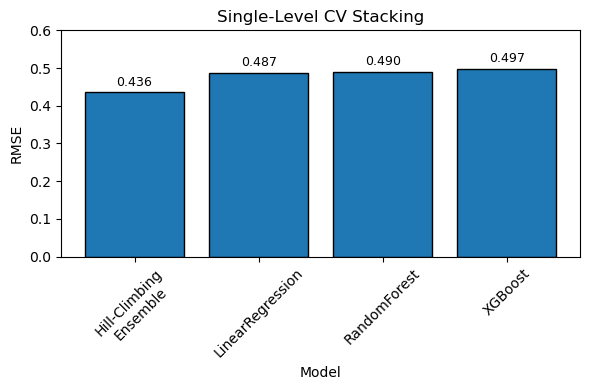

In [26]:
import matplotlib.pyplot as plt


# Recompute individual RMSEs if needed
scores = {
    name: np.sqrt(np.mean((true - oof_preds[:, idx])**2))
    for idx, name in enumerate(files)
}
scores['Hill-Climbing\nEnsemble'] = m

df_scores = (
    pd.Series(scores, name=METRIC)
      .sort_values(ascending=True)  # Lowest bar = best RMSE
      .reset_index()
      .rename(columns={'index': 'Model'})
)

# Plot comparison
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(df_scores['Model'], df_scores[METRIC], edgecolor='black')

# Annotate exact values on top of each bar
for i, v in enumerate(df_scores[METRIC]):
    ax.text(i, v + v*0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

ymax = 0.60  # np.ceil(df_scores[METRIC].max() * 10) / 10
ax.set_ylim(0, ymax)

ax.set_xticks(range(len(df_scores['Model'])))
ax.set_xticklabels(df_scores['Model'], rotation=45)
ax.set_xlabel('Model')
ax.set_ylabel(METRIC)
ax.set_title(f'Single-Level CV Stacking')

plt.tight_layout()
plt.show()

The problem with this approach is that by scoring on the same OOF rows that we used to fit the ensemble this is **hugely optimistic**. That is, every row influenced the hill-climber so the RMSE/MAE that is reported is an **in-sample** statistic and therefore not a real forecast of error.  
  
  If we had a larger dataset then we could keep a completely separate hold-out test set for the final check. Given that our dataset has 50 samples, if we keep even 20% for testing we are left with only 40 points to train three base learners *and* find ensemble weights. This will have high variance, unstable weights, and the test set itself (10 rows) is too small to give a precise estimate of performance on unseen data.  
  
  Given all of this, we will use nested cross-validation. We will keep an outer K-loop and inside each outer-train split we will run the full stacking/hill-climbing procedure, scoring on the outer-test split, and average across the K outer folds. This will allow every observation to act as a pure external exactly once, providing an unbiased estimate (although it will be computationally expensive).

## Predictions on Unseen Data

In [27]:
import cupy as cp
import gc
from sklearn.model_selection import StratifiedKFold


def multiple_rmse_scores(truth, preds):
    """GPU-accelerated vectorised RMSE (preds: N × K)."""
    if not isinstance(truth, cp.ndarray):
        truth = cp.asarray(truth)
    preds = cp.asarray(preds)
    return cp.sqrt(((preds - truth[:, None]) ** 2).mean(axis=0))

def multiple_mae_scores(truth, preds):
    """GPU-accelerated vectorised MAE (preds: N × K)."""
    if not isinstance(truth, cp.ndarray):
        truth = cp.asarray(truth)
    preds = cp.asarray(preds)
    return cp.mean(cp.abs(preds - truth[:, None]), axis=0)



def hill_climb_ensemble(oof_preds, y_true,
                        start=-0.50, stop=0.51, step=0.01,
                        use_negative=True, max_models=1000, tol=1e-5, metric='RMSE'):
    """
    Greedy hill-climber packaged as a function to be called inside each inner CV.
    Returns (selected_indices, final_weights, best_oof_pred).
    """

    x_train2 = cp.asarray(oof_preds)  # (n_samples, n_models)
    truth = cp.asarray(y_true)
    n_models = x_train2.shape[1]

    # Initialise with the single best base model
    if metric.upper() == 'RMSE':
        base_scores = multiple_rmse_scores(truth, x_train2)
    elif metric.upper() == 'MAE':
        base_scores = multiple_mae_scores(truth, x_train2)
    
    best_index = int(cp.argmin(base_scores))
    best_score = float(base_scores[best_index])
    best_ensemble = x_train2[:, best_index]
    indices = [best_index]
    weights = []
    metrics = [best_score]
    old_best_score = best_score

    # Candidate weight grid
    start = start if use_negative else max(0.01, start)
    ww = cp.arange(start, stop, step)

    while True:
        curr_best = np.inf
        curr_idx = -1
        curr_w = 0.0
        candidate = None

        # Search every model with every weight
        for k in range(n_models):
            new_model = x_train2[:, k]
            m1 = best_ensemble[:, None] * (1 - ww)
            m2 = new_model[:, None] * ww
            blend = m1 + m2
            if metric.upper() == 'RMSE':
                scores_ww = multiple_rmse_scores(truth, blend)
            elif metric.upper() == 'MAE':
                scores_ww = multiple_mae_scores(truth, blend)
            best_w_idx = int(cp.argmin(scores_ww))
            if float(scores_ww[best_w_idx]) < curr_best:
                curr_best = float(scores_ww[best_w_idx])
                curr_idx = k
                curr_w = float(ww[best_w_idx])
                candidate = blend[:, best_w_idx]
            del new_model, m1, m2, blend, scores_ww

        gc.collect()

        # Stop?
        if (old_best_score - curr_best) < tol or len(indices) >= max_models:
            break

        # Accept
        indices.append(curr_idx)
        weights.append(curr_w)
        metrics.append(curr_best)
        best_ensemble = candidate
        old_best_score = curr_best

    # Turn sequential weights into final per-model weights
    wgt = np.array([1.0])
    for w in weights:
        wgt = wgt * (1 - w)
        wgt = np.concatenate([wgt, [w]])
    per_model_weights = pd.Series(0.0, index=indices)
    per_model_weights.update(pd.Series(wgt, index=indices))
    per_model_weights = per_model_weights / per_model_weights.sum()  # Normalise

    return indices, per_model_weights.values, best_ensemble.get()

# Nested CV parameters
OUTER_K = 5
INNER_K = 4  # INNER_K < OUTER_K, typically
outer_cv = KFold(n_splits=OUTER_K, shuffle=True, random_state=42)

X_mat = X_enc.values  # numpy for speed
y_vec = y.values
n_samples, n_models = X_mat.shape[0], len(base_models)

# Storage for pure out-of-sample predictions
oof_all = np.empty(n_samples)  # Ensemble predictions
oof_single = np.empty((n_samples, n_models))  # For analysis
outer_scores = []

# Outer loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X_mat)):

    X_tr, X_te = X_mat[train_idx], X_mat[test_idx]
    y_tr, y_te = y_vec[train_idx], y_vec[test_idx]

    # ---------- INNER CV: build OOF matrix for hill climb ----------
    inner_cv = KFold(n_splits=INNER_K, shuffle=True, random_state=fold)
    oof_inner = np.zeros((len(train_idx), n_models))

    for m_idx, (name, model) in enumerate(base_models):
        oof_col = np.zeros(len(train_idx))
        for tr_in, val_in in inner_cv.split(X_tr):
            mdl = clone(model)
            mdl.fit(X_tr[tr_in], y_tr[tr_in])
            oof_col[val_in] = mdl.predict(X_tr[val_in])
        oof_inner[:, m_idx] = oof_col

    # ---------- Hill climb on inner OOF ----------
    chosen_idx, weights, _ = hill_climb_ensemble(oof_inner, y_tr, metric=METRIC)

    # ---------- Re-fit chosen base models on ALL outer-train ----------
    preds_te = np.zeros(len(test_idx))
    for idx_m, w in zip(chosen_idx, weights):
        name, base_model = base_models[idx_m]
        mdl = clone(base_model)
        mdl.fit(X_tr, y_tr)
        preds_te += w * mdl.predict(X_te)

    # ---------- Store outer-fold predictions ----------
    oof_all[test_idx] = preds_te
    if METRIC == 'RMSE':
        outer_scores.append(rmse(y_te, preds_te))
    elif METRIC == 'MAE':
        outer_scores.append(mae(y_te, preds_te))

    # Store single-model OOF preds for diagnostics
    for m_idx, (name, model) in enumerate(base_models):
        mdl = clone(model).fit(X_tr, y_tr)
        oof_single[test_idx, m_idx] = mdl.predict(X_te)

    print(f'[Outer {fold+1}/{OUTER_K}] {METRIC} = {outer_scores[-1]:.5f}')


# Final report
outer_mean = np.mean(outer_scores)
outer_std = np.std(outer_scores, ddof=1)
print(f'\nNested CV {METRIC}  {outer_mean:.5f} ± {outer_std:.5f}')

[Outer 1/5] RMSE = 0.54165
[Outer 2/5] RMSE = 0.37390
[Outer 3/5] RMSE = 0.51424
[Outer 4/5] RMSE = 0.31353
[Outer 5/5] RMSE = 0.53359

Nested CV RMSE  0.45538 ± 0.10462


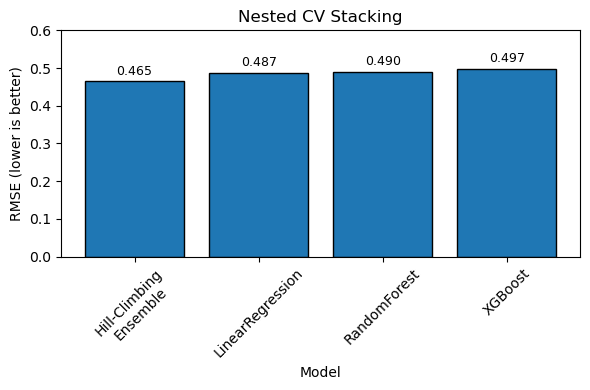

In [28]:
# Collect RMSEs based on pure out-of-sample predictions
if METRIC == 'RMSE':
    scores = {
        name: rmse(y_vec, oof_single[:, idx])
        for idx, (name, _) in enumerate(base_models)
    }
    scores['Hill-Climbing\nEnsemble'] = rmse(y_vec, oof_all)
elif METRIC == 'MAE':
    scores = {
        name: mae(y_vec, oof_single[:, idx])
        for idx, (name, _) in enumerate(base_models)
    }
    scores['Hill-Climbing\nEnsemble'] = mae(y_vec, oof_all)
    
df_scores = (
    pd.Series(scores, name=METRIC)
      .sort_values(ascending=True)  # Lowest bar = best RMSE
      .reset_index()
      .rename(columns={'index': 'Model'})
)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(df_scores['Model'], df_scores[METRIC], edgecolor='black')

ymax = 0.60  # np.ceil(df_scores[METRIC].max() * 10) / 10
ax.set_ylim(0, ymax)

xticks = np.arange(len(df_scores))
ax.set_xticks(xticks)
ax.set_xticklabels(df_scores['Model'], rotation=45)

ax.set_xlabel('Model')
ax.set_ylabel(f'{METRIC} (lower is better)')
ax.set_title(f'Nested CV Stacking')

# Annotate exact values on top of each bar
for i, v in enumerate(df_scores[METRIC]):
    ax.text(i, v + v*0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Conclusions

This study compared two evaluation strategies for a hill-climbing (level-2) regression ensemble built from three base (level-1) learners - 1) **linear regression**, 2) **Random Forest**, and 3) **XGBoost**.  

  The first strategy was a single-level CV stacking. It was built using 5-fold CV to generate out-of-fold (OOF) predictions and train the ensemble. Then, the same OOF rows were used for the evaluation metric (either RMSE or MAE). The ensemble had an RMSE of 0.436 compared to 0.487 - 0.497 for the single models. This improvement, however, reflects **mild data leakage**: the ensemble’s weight search had already *seen* the noise pattern in those OOF rows, so the resulting metric is inherently optimistic.  

  Replacing the initial setup with a 5x4 nested CV strategy eliminated the leakage by assigning every observation to an outer test fold that remained untouched until the very end for the tradeoff of increased computational requirements. Within this nested CV strategy, the ensemble still performs the best, recording an RMSE of 0.465 compared to the 0.487 - 0.497 for the individual models.

  The first scenario did have an RMSE lower than the second strategy. This was expected, as the first scenario was inherently optimistic and exhibited data leakage. The findings of this study are two-fold: first, stacking has genuine predictive power as long as the base models are diverse. Second, the magnitude of the benefits of stacking are sensitive to evaluation leakage - nested CV (or a comparable hold-out strategy) should be considered whenever ensemble weights are tuned on the same data used for performance reporting. Additional work could look to stabilize the stack by exploring weight regularization/Bayesian averaging, expanding the library of base models, fine-tuning the hyperparameters of the base models, and ideally validating the ensemble on a truly external data set.